# Process NYC case and death data by zip code
This notebook processes data from the NYC Department of Health and Mental Hygiene managed [GitHub repository](https://github.com/nychealth/coronavirus-data/tree/master). We read in the following files:
- `trends/caserate-by-modzcta.csv`: case rates per 100,000 people, stratified by **week** and MODZCTA
- `trends/deathrate-by-modzcta.csv`\*: mortality rates per 100,000 people, stratified by **month** and MODZCTA
- `totals/data-by-modzcta.csv` : for population by modzcta to convert between rates and counts

Data are reported at the modified ZIP Code Tabulation Areas (MODZCTA). The modified ZCTA (MODZCTA) geography combines census blocks with smaller populations to allow more stable estimates of population size for rate calculation. More information can be found [here](https://github.com/nychealth/coronavirus-data#geography-zip-codes-and-zctas).

\* *The death rates are suppressed for a specific geography when the count of deaths is between 1 and 4 due to imprecise and unreliable estimates and also to protect patient confidentiality.*



In [1]:
import process_data
from codebook import BOROUGH_FULL_FIPS_DICT

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import plotly.express as px

case_long_df, death_long_df = process_data.process_case_death_zipcode()

ModuleNotFoundError: No module named 'torch'

**DEATH DATA MOSTLY NANS**

Again, the death rates are suppressed for a specific geography when the count of deaths is between 1 and 4 due to imprecise and unreliable estimates and also to protect patient confidentiality. Currently, just filling in NANs with 0.

TODO: Probably it would be more informative if I added borough or neighborhood-level node-features of death data. I think I can get this from 

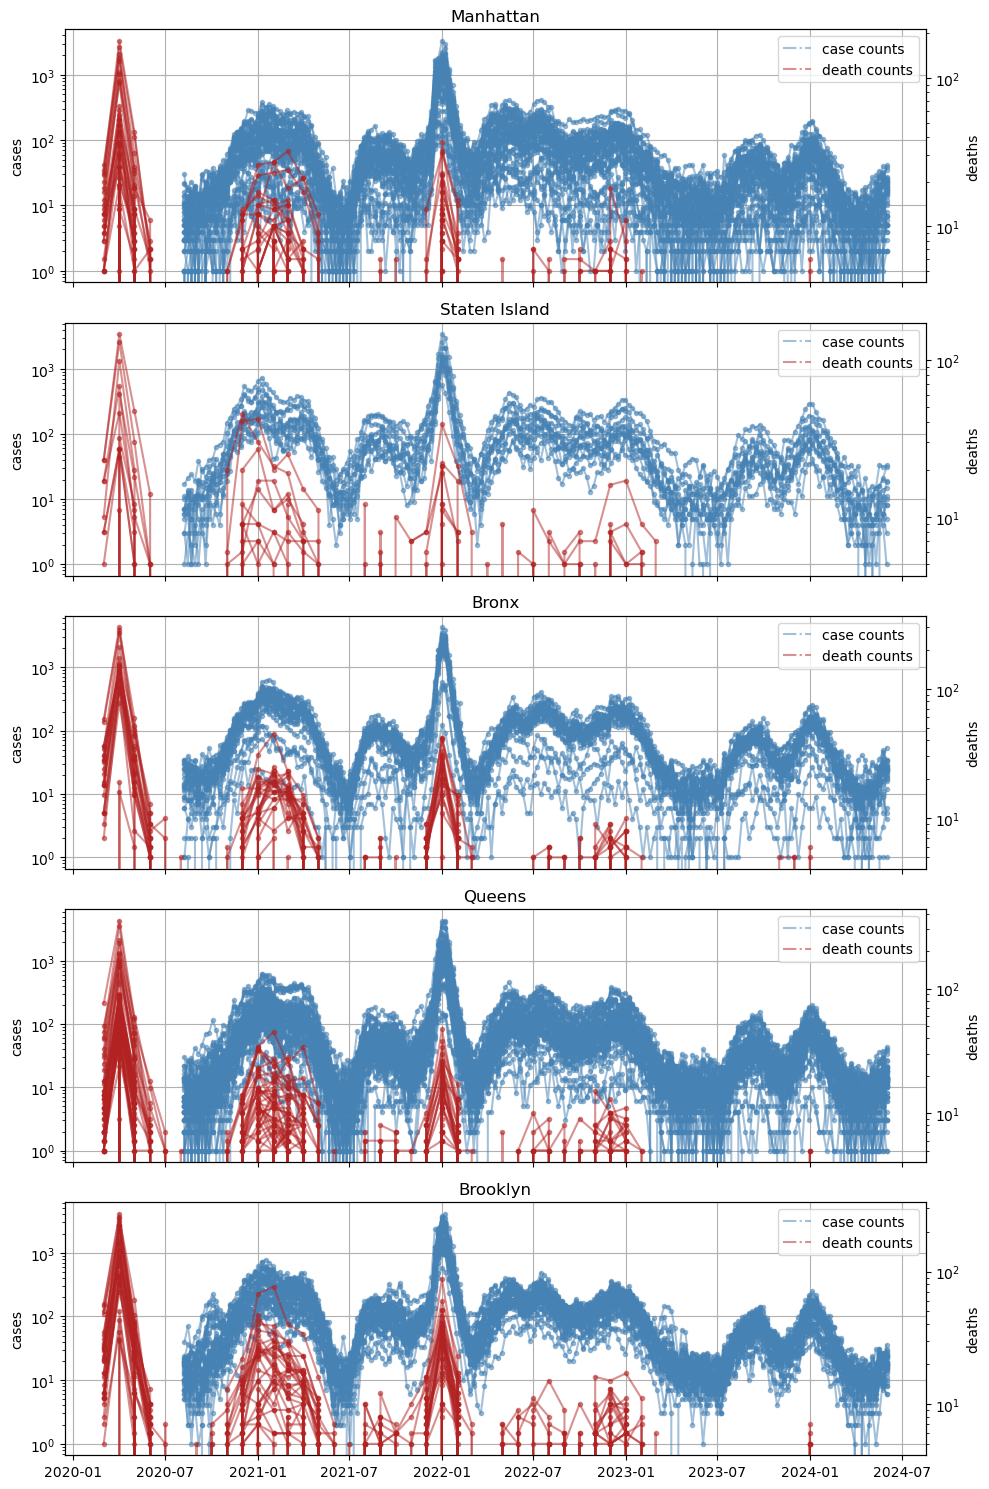

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, figsize=(10,15), sharex=True)

ax_twin = [ax[i].twinx() for i in range(len(ax))]


for i, borough in enumerate(case_long_df['BOROUGH_GROUP'].unique()):
    modzctas = case_long_df.loc[case_long_df['BOROUGH_GROUP'] == borough, 'MODIFIED_ZCTA'].unique()
    for m in modzctas:
        ax[i].plot(
            case_long_df.loc[case_long_df['MODIFIED_ZCTA'] == m, 'week_ending'],
            case_long_df.loc[case_long_df['MODIFIED_ZCTA'] == m, 'CASECOUNT'],
            '.-',
            color='steelblue',
            alpha=0.5,
            label='case counts'
        )

        ax_twin[i].plot(
            death_long_df.loc[death_long_df['MODIFIED_ZCTA'] == m, 'date'],
            death_long_df.loc[death_long_df['MODIFIED_ZCTA'] == m, 'DEATHCOUNT'],
            '.-',
            color='firebrick',
            alpha=0.5,
            label='death counts'
        )

    ax[i].grid()
    
    ax[i].set_ylabel('cases')
    ax_twin[i].set_ylabel('deaths')
    
    case_line = plt.Line2D([0], [0], color='steelblue', alpha=0.5, label='case counts', linestyle='-.')
    death_line = plt.Line2D([0], [0], color='firebrick', alpha=0.5, label='death counts', linestyle='-.')
    ax[i].legend(handles=[case_line, death_line], loc='upper right')
    
    ax[i].set_title(borough)
    
    ax[i].set_yscale('log')
    ax_twin[i].set_yscale('log')
    
plt.tight_layout()


In [3]:
# make crosswalk files

# zip_mzcta_map = {}

# for index, row in totals_df.iterrows():
#     zips = [int(item) for item in row['label'].split(',')]
#     mzcta = int(row['MODIFIED_ZCTA'])

#     for z in zips:
#         zip_mzcta_map[z] = mzcta

# df = pd.DataFrame.from_dict(zip_mzcta_map, orient='index').reset_index()
# df = df.rename(columns={"index": "zipcode", 0: "mzcta"})
# df.to_csv('../data/raw/zip_mzcta_crosswalk.csv', index=False)

# totals_df[['MODIFIED_ZCTA', 'NEIGHBORHOOD_NAME', 'BOROUGH_GROUP']].to_csv('../data/raw/mzcta_borough_crosswalk.csv', index=False)

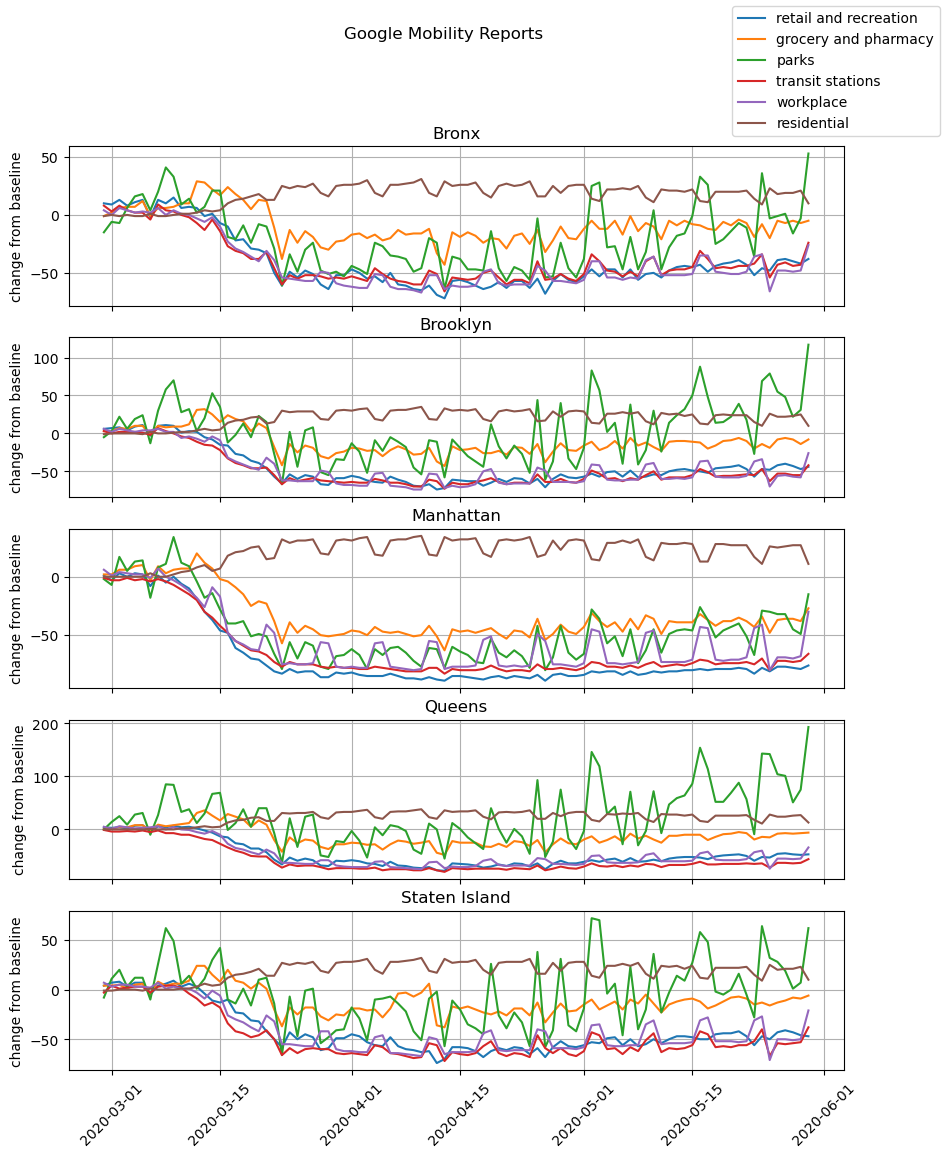

In [4]:
nyc_mobility_report_df = process_data.process_mobility_report()

fig, ax = plt.subplots(5, figsize=(10,12), sharex=True)

for i, f in enumerate(nyc_mobility_report_df.FIPS.unique()):
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'retail_and_recreation_percent_change_from_baseline'], label='retail and recreation')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'grocery_and_pharmacy_percent_change_from_baseline'], label='grocery and pharmacy')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'parks_percent_change_from_baseline'], label='parks')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'transit_stations_percent_change_from_baseline'], label='transit stations')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'workplaces_percent_change_from_baseline'], label='workplace')
    ax[i].plot(nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f, 'date'],
               nyc_mobility_report_df.loc[nyc_mobility_report_df.FIPS == f,'residential_percent_change_from_baseline'], label='residential')

    ax[i].grid()
    ax[i].set_title(BOROUGH_FULL_FIPS_DICT[f])
    ax[i].set_ylabel(r'change from baseline')

plt.xticks(rotation=45)
handles, labels = ax[0].get_legend_handles_labels()
fig.suptitle("Google Mobility Reports")
fig.legend(handles, labels, loc='upper right')
# fig.savefig("../assets/google_mobility_reports.png")

In [5]:
nyc_df = pd.read_csv("../data/raw/2021_harddrive_nyc.csv")
nyc_df_2020 = pd.read_csv("../data/raw/2020_harddrive_nyc.csv")
nyc_df = pd.concat([nyc_df_2020, nyc_df])

nyc_df['mzcta_orig'] = nyc_df['mzcta_orig'].astype('str')
nyc_df['mzcta_dest'] = nyc_df['mzcta_dest'].astype('str')

nyc_df['log_visitor_home_aggregation'] = np.log(nyc_df['visitor_home_aggregation'])

nyc_df['date_range_start'] = pd.to_datetime(nyc_df['date_range_start'], utc=True)
nyc_df['date_range_start'] = nyc_df['date_range_start'].dt.date

nyc_df['date_range_end'] = pd.to_datetime(nyc_df['date_range_end'], utc=True)
nyc_df['date_range_end'] = nyc_df['date_range_end'].dt.date

# import xarray as xr

# nyc_xr = xr.Dataset.from_dataframe(nyc_df.set_index(['date_range_start', 'label_mzcta_orig', 'label_mzcta_dest']))

# fig2 = px.imshow(
#     np.log(nyc_xr.visitor_home_aggregation.mean(dim=["date_range_start"])).fillna(0),
#     zmin=0,
#     zmax=10.5,
#     x=nyc_xr.label_mzcta_orig,
#     y=nyc_xr.label_mzcta_dest,
#     labels={'x': 'label_mzcta_orig', 'y': 'label_mzcta_dest', 'color': 'log_visitor_home_aggregation'},
#     text_auto=True,
#     color_continuous_scale="Blues",
#     aspect='equal',
#     height=1000,
#     width=1000,
#     title='SafeGraph (HardDrive) Mobility - NYC by zip code - Average over time (3/2020 - 12/2021)',
# )

# fig2.update_xaxes(side='top')
# fig2.show()


In [6]:
borough_df = nyc_df.groupby(['date_range_start', 'date_range_end', 'borough_orig', 'borough_dest'])['visitor_home_aggregation'].sum().reset_index()

borough_df['route'] = borough_df['borough_orig'] + '_' + borough_df['borough_dest']

# fig, ax = plt.subplots(5, figsize=(10,15), sharex=True)

# for i, b in enumerate(borough_df['borough_orig'].unique()):
#     sub_df = borough_df.loc[borough_df['borough_orig'] == b]
#     for r in sub_df['route'].unique():
#         ax[i].plot(
#             sub_df.loc[sub_df['route'] == r, 'date_range_start'], 
#             sub_df.loc[sub_df['route'] == r, 'visitor_home_aggregation'],
#             '.-',
#             label=r,
#         )

#     ax[i].grid()
#     ax[i].legend()
#     ax[i].set_title(f"{b} orig")

#     # ax[i].set_yscale('log')
#     ax[i].set_ylabel('visitor_home_aggregation')

# ax[-1].set_xlabel('date_range_start')

# fig.suptitle('SafeGraph (HardDrive) Mobility - NYC by borough')
# plt.tight_layout()

# Test GCN model
Using weekly case data from 2020-08-08 to 2020-12-26 and monthly (01/2021 is when first fully vaccinated in NYC)

Train: 2020-08-08 to 2020-10-10
Test: 2020-10-10 to 2020-12-26

TODO: zipcode-level vaccine data???

In [30]:
dates[-1]

Timestamp('2020-12-26 00:00:00')

In [7]:
from utils import get_date_range, get_fips_list

def create_node_key(dates, mzcta_list):

    node_dict = dict()

    curr_idx = 0
    for d in dates:
        for m in mzcta_list:
            key_str = f"{m}-{d.strftime('%Y-%m-%d')}"
            node_dict[key_str] = curr_idx
            curr_idx += 1

    return node_dict

dates = case_long_df.loc[case_long_df.week_ending <= '2020-12-31', 'week_ending'].unique()
mzcta_list = case_long_df.MODIFIED_ZCTA.unique()

# process data
# case_long_df, death_long_df = process_data.process_case_death_zipcode()
node_dict = create_node_key(dates, mzcta_list)
# nyc_mobility_report_df = process_data.process_mobility_report()
coo_df = process_data.create_edge_index(node_dict, dates, mzcta_list)


657909 spatial edges
6726 temporal edges


In [10]:
subset_nyc_df = nyc_df.loc[(nyc_df['date_range_start'] >= (dates[0].date() + pd.offsets.Week(n=0, weekday=0)).date()) & 
(nyc_df['date_range_start'] <= (dates[-1].date() + pd.offsets.Week(n=0, weekday=0)).date())].date_range_start.unique()

In [11]:
from tqdm import tqdm 

day_mobility_dict = dict()

for d in dates:
    next_sunday = d.date() + pd.offsets.Week(n=0, weekday=0)
    day_key = d.strftime("%Y-%m-%d")
    day_mobility_dict[day_key] = next_sunday

node_keys = list(node_dict.keys())

edge_weights = []

for row in tqdm(coo_df.iterrows()):
    orig = row[1][0]
    dest = row[1][1]

    orig_key = node_keys[orig]
    dest_key = node_keys[dest]

    orig_fips, orig_date = orig_key.split("-", maxsplit=1)
    dest_fips, dest_date = dest_key.split("-", maxsplit=1)

    if orig_date != dest_date:
        # temportal edge with no edge weight
        edge_weights.append(1)
    else:
        try:
            ew = subset_nyc_df.loc[(subset_nyc_df['date_range_start'] == day_mobility_dict[orig_date].date()) & (subset_nyc_df['mzcta_orig'] == orig_fips) & (subset_nyc_df['mzcta_dest'] == dest_fips), 'visitor_home_aggregation'].values[0]
        except:
            ew = 0
        edge_weights.append(ew)

664635it [00:14, 46520.99it/s]


In [12]:
train_mask, test_mask = process_data.create_train_test_mask(node_dict, dates, mzcta_list)

In [13]:
print(sum(train_mask))
len(train_mask)

1770


3717

In [14]:
deltaT = pd.Timedelta(value=7, unit="D")

case_long_df = case_long_df.sort_values(by=["week_ending", "MODIFIED_ZCTA"])
case_long_df["CASE_DELTA"] = (
    case_long_df.groupby(["MODIFIED_ZCTA"])["CASECOUNT"].diff(-1).fillna(0)
)
case_long_df["CASE_DELTA"] = case_long_df["CASE_DELTA"] * -1

case_long_df.reset_index(inplace=True)

In [17]:
import torch
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# make everything a tensor
coo_t = torch.tensor(coo_df.values, dtype=torch.int64)
coo_t = coo_t.reshape((2, len(coo_df.values)))

edge_weight_tensor = torch.tensor(edge_weights, dtype=torch.float32)

# x_t = case_subset_df.merge(
#     death_subset_df, on=["date_of_interest", "FIPS", "node_key"]
# )
case_subset_df = case_long_df.loc[case_long_df.week_ending <= '2020-12-31']
x_t = case_subset_df
# x_t = x_t.merge(
#     nyc_mobility_report_df,
#     left_on=["week_ending", "FIPS"],
#     right_on=["date", "FIPS"],
# )
x_t_cols = [
    # 'MODIFIED_ZCTA', 'POP_DENOMINATOR',
    'CASECOUNT', 'CASE_DELTA',
    # "retail_and_recreation_percent_change_from_baseline",
    # "grocery_and_pharmacy_percent_change_from_baseline",
    # "parks_percent_change_from_baseline",
    # "transit_stations_percent_change_from_baseline",
    # "workplaces_percent_change_from_baseline",
    # "residential_percent_change_from_baseline",
]
# x_t[x_t_cols].to_csv(f"../data/processed/{version}/x_t.csv", index=False)
x_t = torch.tensor(x_t[x_t_cols].values, dtype=torch.float32)
y_t = case_subset_df["CASE_DELTA"] + case_subset_df["CASECOUNT"]
# y_t.to_csv(f"../data/processed/{version}/y_t.csv", index=False)
y_t = torch.tensor(
    y_t.values,
    dtype=torch.float32,
)
data = Data(
    x=x_t.to(device),
    y=y_t.to(device),
    edge_index=coo_t.to(device),
    edge_weight=edge_weight_tensor.to(device),
)

data.train_mask = torch.tensor(np.array(train_mask), dtype=torch.bool).to(device)
data.test_mask = torch.tensor(np.array(test_mask), dtype=torch.bool).to(device)

In [25]:
case_subset_df.head()

,index,week_ending,MODIFIED_ZCTA,CASERATE_BK,CASERATE_BX,CASERATE_CITY,CASERATE_MN,CASERATE_QN,CASERATE_SI,CASERATE,BOROUGH_GROUP,POP_DENOMINATOR,CASECOUNT,node_key,CASE_DELTA
0,0,2020-08-08,10001,20.08,28.84,20.74,17.99,19.12,17.22,7.24,Manhattan,27613.09,2,10001-2020-08-08,2.0
1,200,2020-08-08,10002,20.08,28.84,20.74,17.99,19.12,17.22,39.83,Manhattan,75322.71,30,10002-2020-08-08,-22.0
2,400,2020-08-08,10003,20.08,28.84,20.74,17.99,19.12,17.22,7.41,Manhattan,53977.81,4,10003-2020-08-08,-0.0
3,600,2020-08-08,10004,20.08,28.84,20.74,17.99,19.12,17.22,0.00,Manhattan,2972.12,0,10004-2020-08-08,-0.0
4,800,2020-08-08,10005,20.08,28.84,20.74,17.99,19.12,17.22,22.84,Manhattan,8757.23,2,10005-2020-08-08,3.0


In [20]:
from tqdm import tqdm
import importlib
import model #import the module here, so that it can be reloaded.
importlib.reload(model)
from model import GCN, RMSLELoss
from torch_geometric.nn import summary


graph = data.to(device)
print(graph)

model     = GCN().to(device)
print(summary(model, graph.x, graph.edge_index))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=5e-4)
criterion = RMSLELoss()

def train():
	model.train()
	optimizer.zero_grad()
	out, _ = model(graph.x.to(device), graph.edge_index.to(device))
	loss = criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test():
	model.eval()
	out, _  = model(graph.x, graph.edge_index)
	loss = criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

	return loss

train_loss = []
test_loss = []
for epoch in tqdm(range(10000)):
	loss = train()
	train_loss.append(loss.cpu().detach().numpy())
	loss = test()
	test_loss.append(loss.cpu().detach().numpy())

print("final test loss: {}".format(test_loss[-1]))

Data(x=[3717, 2], edge_index=[2, 664635], y=[3717], edge_weight=[664635], train_mask=[3717], test_mask=[3717])
+---------------------+-------------------------+----------------------+----------+
| Layer               | Input Shape             | Output Shape         | #Param   |
|---------------------+-------------------------+----------------------+----------|
| GCN                 | [3717, 2], [2, 664635]  | [3717, 1], [3717, 1] | 3,297    |
| ├─(MLP_embed)Linear | [3717, 2]               | [3717, 32]           | 96       |
| ├─(conv1)GCNConv    | [3717, 32], [2, 664635] | [3717, 32]           | 1,056    |
| ├─(conv2)GCNConv    | [3717, 64], [2, 664635] | [3717, 32]           | 2,080    |
| ├─(MLP_pred)Linear  | [3717, 64]              | [3717, 1]            | 65       |
+---------------------+-------------------------+----------------------+----------+


100%|██████████| 10000/10000 [01:28<00:00, 113.33it/s]

final test loss: 0.3719724416732788


In [21]:
model.eval()
out, _  = model(graph.x, graph.edge_index)
print("train loss", criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask]))
print("test loss", criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask]))
print("train corr", torch.corrcoef(torch.stack((out[graph.train_mask].squeeze(), graph.y[graph.train_mask])))[0,1])
print("test corr", torch.corrcoef(torch.stack((out[graph.test_mask].squeeze(), graph.y[graph.test_mask])))[0,1])
y_test = graph.y[graph.test_mask].cpu().numpy()
out_test = out[graph.test_mask].detach().cpu().numpy()

y_train = graph.y[graph.train_mask].cpu().numpy()
out_train = out[graph.train_mask].detach().cpu().numpy()



train loss tensor(0.1157, device='cuda:0', grad_fn=<SqrtBackward0>)
test loss tensor(0.3720, device='cuda:0', grad_fn=<SqrtBackward0>)
train corr tensor(0.9973, device='cuda:0', grad_fn=<SelectBackward0>)
test corr tensor(0.9964, device='cuda:0', grad_fn=<SelectBackward0>)


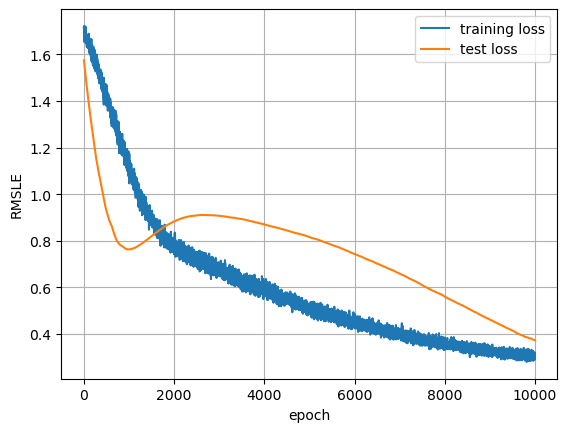

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(train_loss, label='training loss')
ax.plot(test_loss, label='test loss')
ax.set_xlabel('epoch')
ax.set_ylabel('RMSLE')
ax.grid()
ax.legend()

Text(0.5, 1.0, 'Training set')

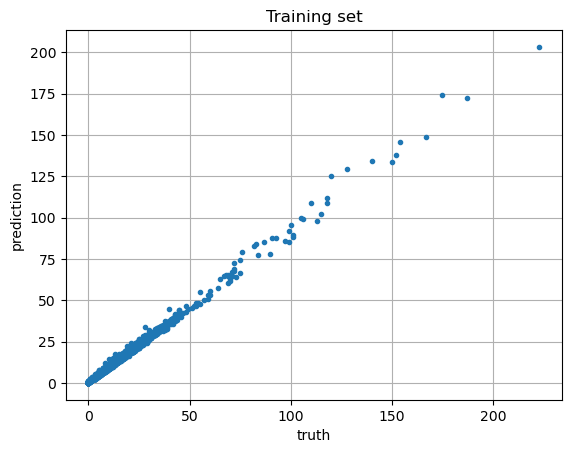

In [23]:
fig, ax = plt.subplots()
ax.plot(y_train, out_train, '.')
ax.grid()
ax.set_xlabel('truth')
ax.set_ylabel('prediction')
ax.set_title('Training set')

Text(0.5, 1.0, 'Test set')

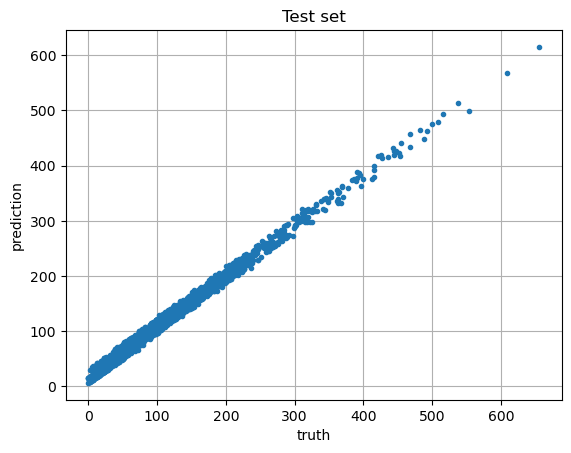

In [24]:
fig, ax = plt.subplots()
ax.plot(y_test, out_test, '.')
ax.grid()
ax.set_xlabel('truth')
ax.set_ylabel('prediction')
ax.set_title('Test set')

In [21]:
 np.array(list(node_dict.keys()))[np.where(np.array(graph.test_mask.cpu().numpy())==1)]

array(['10001-2020-10-17', '10002-2020-10-17', '10003-2020-10-17', ...,
       '11693-2020-12-26', '11694-2020-12-26', '11697-2020-12-26'],
      dtype='<U16')

In [26]:
# import pandas as pd
# import numpy as np

# node_dict = process_data.create_node_key()

# pred_df = pd.DataFrame()
# pred_df['key'] = np.array(list(node_dict.keys()))[np.where(np.array(graph.test_mask.cpu().numpy())==1)]
# pred_df['truth'] = y_test
# pred_df['pred'] = out_test

# pred_df[['fips','date']] = pred_df['key'].str.split('-',n=1, expand=True)
# pred_df['date'] = pd.to_datetime(pred_df['date'])

# train_df = pd.DataFrame()
# train_df['key'] = np.array(list(node_dict.keys()))[np.where(np.array(graph.train_mask.cpu().numpy())==1)]
# train_df['truth'] = y_train
# train_df['pred'] = out_train

# train_df[['fips','date']] = train_df['key'].str.split('-',n=1, expand=True)
# train_df['date'] = pd.to_datetime(train_df['date'])

In [27]:
# fig, ax = plt.subplots(5, figsize=(12,15), sharex=True)

# for i, f in enumerate(fips_list):
#     ax[i].plot(pred_df.loc[pred_df['fips'] == str(f), 'date'], pred_df.loc[pred_df['fips'] == str(f), 'pred'].values, '.-.', label='prediction')
#     ax[i].plot(pred_df.loc[pred_df['fips'] == str(f), 'date'], pred_df.loc[pred_df['fips'] == str(f), 'truth'].values, '-', label='truth')

#     ax[i].plot(train_df.loc[train_df['fips'] == str(f), 'date'], train_df.loc[train_df['fips'] == str(f), 'pred'].values, '.-.', label='training prediction')
#     ax[i].plot(train_df.loc[train_df['fips'] == str(f), 'date'], train_df.loc[train_df['fips'] == str(f), 'truth'].values, '-', label='truth')
    
#     ax[i].grid()
#     ax[i].legend()
#     ax[i].set_title(BOROUGH_FULL_FIPS_DICT[f])
#     ax[i].set_ylabel(r'i(t+1)')

# plt.xticks(rotation=45)
